In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### 3. train/valid/test split

In [3]:
%%time
import zipfile
import requests
import os
import io
from urllib.parse import urlencode

public_key1 = "https://disk.yandex.ru/d/LekAiEuhxzxwTA"
folder_name1 = "Архив"
asset_zip_path1 = os.path.join(os.getcwd(), f"{folder_name1}.zip")




def download_and_unzip(load_from):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

  # Получаем загрузочную ссылку
  final_url = base_url + urlencode(dict(public_key=load_from))
  try:
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    print('Success! The data has been loaded')
  except:
    "Could not load the content of the URL"

  print("Unpacking the data...")
  try:
    extract_to = os.getcwd()

    z = zipfile.ZipFile(io.BytesIO(download_response.content))
    z.extractall(extract_to)
    print(f'Done! The data is available here {extract_to}')
  except:
    "Error occured while extracting the data"



# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path1):
    download_and_unzip(public_key1)


Success! The data has been loaded
Unpacking the data...
Done! The data is available here /content
CPU times: user 13.4 s, sys: 4.19 s, total: 17.6 s
Wall time: 1min 21s


In [6]:
df_1hour = load_pkl('./data_1hour.pkl')
df_1day = load_pkl('./data_1day.pkl')


# df_1hour = load_pkl('data/feat_engin/lgbm/data_1hour.pkl')
# df_1day = load_pkl('data/feat_engin/lgbm/data_1day.pkl')



### target

In [ ]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])

    df = df_all.iloc[ind:ind_end].copy()

    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]

    if val_first < val_second:
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else:
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)


    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):


        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind

    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []

    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]

        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)

        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]


    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers,
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result

In [ ]:
df_result = load_pkl('./data/feat_engin/df_result_wait_35_7days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

In [ ]:
inds = np.arange(df_result.shape[0])
inds.shape

(972611,)

In [ ]:
df_result = get_df_target(df_result, inds, percent_first=0.99, percent_second=1.04, points_to_wait=14*2)

df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.99)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.04)

100%|███████████████████████████████████████████████████████████████| 972611/972611 [03:52<00:00, 4188.82it/s]


In [ ]:
dump_pkl(df_result, './data/feat_engin/df_result_wait_14_2days.pkl')

In [ ]:
(df_result['ind'] == df_result.index).all(),

(True,)

In [ ]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]

In [ ]:
df_1hour.shape

(972611, 231)

In [ ]:
#join
df_1hour = df_1hour[df_1hour.columns[~df_1hour.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df_1hour.shape

(972611, 231)

In [ ]:
df_1hour.head()

,time,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,...,volume_w70_ma_up_3std/volume,tmos_close_w70_ma_low_2std/tmos_close,tmos_close_w70_ma_up_2std/tmos_close,tmos_close_w70_ma_low_3std/tmos_close,tmos_close_w70_ma_up_3std/tmos_close,result,delta_time,income_rate,res_price,res_ind
0,2022-05-04 10:00:00,AFLT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 01:00:00,0.98,31.38,1
1,2022-05-04 11:00:00,AFLT,NaN,-0.022430,-0.619246,-0.016393,0.016040,0.022430,-1.388889,0.000000,...,5.263229,0.984763,1.031904,0.972978,1.043689,LOSE,1 days 05:00:00,0.98,30.64,15
2,2022-05-04 12:00:00,AFLT,NaN,0.013384,-0.534310,0.004762,0.011387,0.017907,-1.146789,36.842106,...,10.178883,0.985282,1.019458,0.976738,1.028002,LOSE,0 days 04:00:00,0.98,31.16,6
3,2022-05-04 13:00:00,AFLT,NaN,-0.013836,-0.014867,-0.002370,0.011265,0.016550,-2.358490,26.582279,...,9.178177,0.988793,1.018333,0.981408,1.025718,LOSE,1 days 03:00:00,0.98,30.64,15
4,2022-05-04 14:00:00,AFLT,NaN,0.005740,-0.207645,0.000000,0.009909,0.013848,-2.899878,34.090908,...,10.562762,0.989668,1.016033,0.983077,1.022624,LOSE,1 days 02:00:00,0.98,30.64,15


### next

In [7]:
df_1hour['result'].value_counts(normalize=True)

,proportion
result,
DNF,0.469738
LOSE,0.362043
WIN,0.168219


In [8]:
df_1hour['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

,income_rate
0.00,0.980000
0.01,0.980000
0.10,0.980000
0.20,0.980000
0.30,0.980000
0.40,0.988005
0.50,0.996865
0.60,1.003846
0.70,1.012394
0.80,1.026795


In [9]:
df_1hour.head()

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,tmos_close_w70_ma_up_3std/tmos_close,close_w5_min/close_w5_max,volume_w5_min/volume_w5_max,tmos_close_w5_min/tmos_close_w5_max,close_w14_min/close_w14_max,volume_w14_min/volume_w14_max,tmos_close_w14_min/tmos_close_w14_max,close_w70_min/close_w70_max,volume_w70_min/volume_w70_max,tmos_close_w70_min/tmos_close_w70_max
index,,,,,,,,,,,,,,,,,,,,,
0,2022-05-04 10:00:00,32.099998,AFLT,NaN,LOSE,0 days 01:00:00,0.98,31.379999,1,NaN,...,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2022-05-04 11:00:00,31.379999,AFLT,NaN,LOSE,1 days 05:00:00,0.98,30.639999,15,-0.022430,...,1.043689,0.977570,0.380754,0.983606,0.977570,0.380754,0.983606,0.977570,0.380754,0.983606
2,2022-05-04 12:00:00,31.799999,AFLT,NaN,LOSE,0 days 04:00:00,0.98,31.160000,6,0.013384,...,1.028002,0.977570,0.177313,0.983606,0.977570,0.177313,0.983606,0.977570,0.177313,0.983606
3,2022-05-04 13:00:00,31.360001,AFLT,NaN,LOSE,1 days 03:00:00,0.98,30.639999,15,-0.013836,...,1.025718,0.976947,0.174677,0.983606,0.976947,0.174677,0.983606,0.976947,0.174677,0.983606
4,2022-05-04 14:00:00,31.540001,AFLT,NaN,LOSE,1 days 02:00:00,0.98,30.639999,15,0.005740,...,1.022624,0.976947,0.138406,0.983606,0.976947,0.138406,0.983606,0.976947,0.138406,0.983606


In [10]:
df_1day.head()

,index,time,ticker,close_1day_w1_roc,volume_1day_w1_roc,tmos_close_1day_w1_roc,close_1day_w3_norm_std,close_1day_w3_mean_abs_pct,close_1day_w3_alpha,close_1day_w3_rsi,...,tmos_close_1day_w100_ma_up_3std/tmos_close_1day,close_1day_w3_min/close_1day_w3_max,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max
0,0,2022-05-04 23:00:00,AFLT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,2022-05-05 23:00:00,AFLT,-0.016026,-0.416498,0.009569,0.011423,0.016026,-2.000000,0.0,...,1.015368,0.983974,0.583502,0.990521,0.983974,0.583502,0.990521,0.983974,0.583502,0.990521
2,2,2022-05-06 23:00:00,AFLT,-0.019544,-0.538980,-0.007109,0.017959,0.017785,-1.813187,0.0,...,1.016496,0.964744,0.269006,0.990521,0.964744,0.269006,0.990521,0.964744,0.269006,0.990521
3,3,2022-05-11 23:00:00,AFLT,-0.005980,0.252535,0.007160,0.013506,0.013850,-2.338130,0.0,...,1.010509,0.974593,0.461020,0.992891,0.958974,0.269006,0.990521,0.958974,0.269006,0.990521
4,4,2022-05-12 23:00:00,AFLT,-0.020053,-0.176090,-0.037915,0.013714,0.015193,-2.338130,0.0,...,1.076981,0.974086,0.798381,0.962085,0.939744,0.269006,0.962085,0.939744,0.269006,0.962085


In [11]:
(df_1day['index'] == df_1day.index).all()

True

### Normalization data

In [12]:
from sklearn.preprocessing import StandardScaler

cols_exclude_1hour = ['time', 'ticker', 'close',
                     'index_1day',
                     'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
cols = df_1hour.columns[~df_1hour.columns.isin(cols_exclude_1hour)]

#scaler = load_pkl('./scaler_1min.pkl')
scaler = StandardScaler()
df_1hour[cols] = scaler.fit_transform(df_1hour[cols])


cols_exclude_1day = ['time', 'ticker', 'index']
cols = df_1day.columns[~df_1day.columns.isin(cols_exclude_1day)]
#scaler = load_pkl('./scaler_1day.pkl')
scaler = StandardScaler()
df_1day[cols] = scaler.fit_transform(df_1day[cols])

In [13]:
df_1hour

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,tmos_close_w70_ma_up_3std/tmos_close,close_w5_min/close_w5_max,volume_w5_min/volume_w5_max,tmos_close_w5_min/tmos_close_w5_max,close_w14_min/close_w14_max,volume_w14_min/volume_w14_max,tmos_close_w14_min/tmos_close_w14_max,close_w70_min/close_w70_max,volume_w70_min/volume_w70_max,tmos_close_w70_min/tmos_close_w70_max
index,,,,,,,,,,,,,,,,,,,,,
0,2022-05-04 10:00:00,32.099998,AFLT,NaN,LOSE,0 days 01:00:00,0.980000,31.379999,1,NaN,...,NaN,0.859200,5.643632,1.036863,1.042237,21.063971,1.284413,1.321434,54.356834,1.647947
1,2022-05-04 11:00:00,31.379999,AFLT,NaN,LOSE,1 days 05:00:00,0.980000,30.639999,15,-2.317642,...,0.274822,-0.585032,1.380160,-1.689319,0.229805,7.354105,-0.190400,0.939100,20.340071,0.998780
2,2022-05-04 12:00:00,31.799999,AFLT,NaN,LOSE,0 days 04:00:00,0.980000,31.160000,6,1.368788,...,-0.148844,-0.585032,-0.020518,-1.689319,0.229805,2.850006,-0.190400,0.939100,9.164550,0.998780
3,2022-05-04 13:00:00,31.360001,AFLT,NaN,LOSE,1 days 03:00:00,0.980000,30.639999,15,-1.433103,...,-0.210512,-0.625147,-0.038668,-1.689319,0.207239,2.791642,-0.190400,0.928480,9.019738,0.998780
4,2022-05-04 14:00:00,31.540001,AFLT,NaN,LOSE,1 days 02:00:00,0.980000,30.639999,15,0.581922,...,-0.294082,-0.625147,-0.288390,-1.689319,0.207239,1.988620,-0.190400,0.928480,7.027290,0.998780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000391,2025-01-23 19:00:00,11.625000,RBCM,87288.0,DNF,0 days 04:00:00,1.006452,11.700000,1000395,0.480418,...,-0.294288,0.444497,-1.116348,-0.000867,0.701113,-0.930403,0.444943,0.592861,-0.542623,0.429514
1000392,2025-01-23 20:00:00,11.680000,RBCM,87288.0,DNF,0 days 03:00:00,1.001712,11.700000,1000395,0.478103,...,-0.427354,0.252795,-1.116348,-0.000867,0.701113,-0.930403,0.444943,0.592861,-0.542623,0.429514
1000393,2025-01-23 21:00:00,11.600000,RBCM,87288.0,DNF,0 days 02:00:00,1.008621,11.700000,1000395,-0.713901,...,-0.391477,0.252795,-1.221738,-0.000867,0.701113,-1.012706,0.444943,0.592861,-0.542623,0.429514


In [14]:
df_1hour[df_1hour.columns[~df_1hour.columns.isin(cols_exclude_1hour)]].abs().max().max()

994.9898907786065

In [15]:
df_1day[df_1day.columns[~df_1day.columns.isin(cols_exclude_1day)]].abs().max().max()

295.44708251953125

In [16]:
df_1hour['target'] = (df_1hour['result'] == 'WIN').astype(int)

<ipython-input-16-f7743fd744a3>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1hour['target'] = (df_1hour['result'] == 'WIN').astype(int)


<Axes: xlabel='time'>

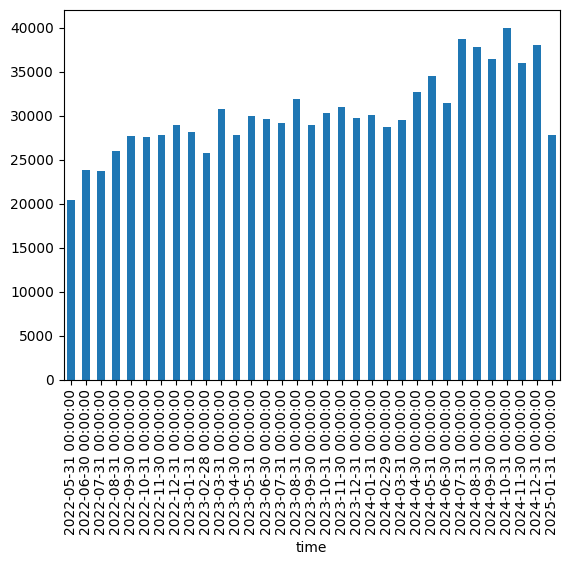

In [17]:
df_1hour[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

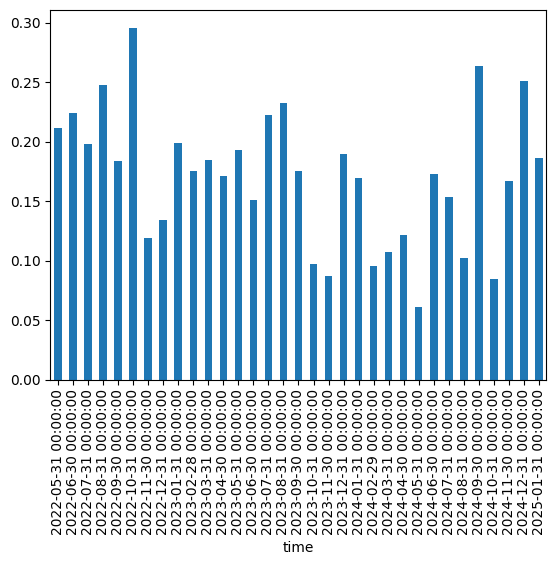

In [18]:
df_1hour[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

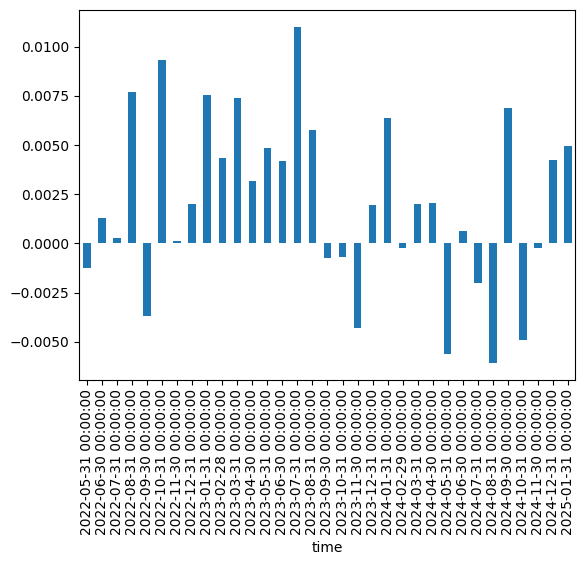

In [19]:
(df_1hour[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean() -1).plot.bar()

In [20]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df_1hour['time']) & (df_1hour['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1hour['time']) & (df_1hour['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1hour['time']) & (df_1hour['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1hour['time']) & (df_1hour['time'] < pd.Timestamp('2024-12-23')))
mask_test3 = np.array((pd.Timestamp('2024-12-23') <= df_1hour['time']) & (df_1hour['time'] < pd.Timestamp('2025-01-17')))

mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(714252, 70129, 74239, 101909)

In [21]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 210
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df_1hour["ticker"].unique():
    mask = np.array(df_1hour['ticker'] == ticker)
    count_days = df_1hour.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df_1hour.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df_1hour["time"] >= pd.to_datetime(date_first_avbl))

    mask_ticker = np.array(df_1hour['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all

In [22]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(453449, 70129, 74239, 101909)

In [23]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

699726

In [24]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.6480379462818303,
 0.10022351606200142,
 0.10609724377827892,
 0.14564129387788935)

In [25]:
df_1hour.loc[mask_train, 'target'].mean(), df_1hour.loc[mask_valid, 'target'].mean(), df_1hour.loc[mask_test, 'target'].mean(), df_1hour.loc[mask_test2, 'target'].mean()

(0.1490818151545157,
 0.16215830826049138,
 0.1812928514662105,
 0.15419639089776171)

In [26]:
df_1hour.loc[mask_train, 'income_rate'].mean(), df_1hour.loc[mask_valid, 'income_rate'].mean(), df_1hour.loc[mask_test, 'income_rate'].mean(), df_1hour.loc[mask_test2, 'income_rate'].mean()

(1.0024161, 0.9991569, 1.0002859, 0.9984382)

In [27]:
#проверки

In [28]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) == mask_data.sum()

True

In [29]:
#indexes

inds_train = df_1hour.index[mask_train].values
inds_valid = df_1hour.index[mask_valid].values
inds_test = df_1hour.index[mask_test].values
inds_test2 = df_1hour.index[mask_test2].values

In [30]:
inds_train

array([  2471,   2472,   2473, ..., 998116, 998117, 998118])

### 4. Model Khibiny

In [31]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [32]:
df_1hour['ticker_code'] = df_1hour['ticker'].astype('category').cat.codes

<ipython-input-32-f5a901c0c77c>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1hour['ticker_code'] = df_1hour['ticker'].astype('category').cat.codes


In [33]:
df_1hour['ticker_code'].value_counts()

,count
ticker_code,
103,9585
15,9400
44,9400
25,9400
90,9400
...,...
4,6602
87,6537
16,6496


In [34]:
df_1hour['ticker_code'].max()

126

In [35]:
df_1hour.loc[mask_train, 'ticker_code'].max()

126

In [36]:
pd.set_option("display.max_rows", 20)
df_1hour.loc[mask_train, 'ticker_code'].value_counts().min()

1759

In [37]:
#dict(enumerate(df_1hour['ticker'].astype('category').cat.categories))

In [38]:
df_1hour.head()

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,volume_w5_min/volume_w5_max,tmos_close_w5_min/tmos_close_w5_max,close_w14_min/close_w14_max,volume_w14_min/volume_w14_max,tmos_close_w14_min/tmos_close_w14_max,close_w70_min/close_w70_max,volume_w70_min/volume_w70_max,tmos_close_w70_min/tmos_close_w70_max,target,ticker_code
index,,,,,,,,,,,,,,,,,,,,,
0,2022-05-04 10:00:00,32.099998,AFLT,NaN,LOSE,0 days 01:00:00,0.98,31.379999,1,NaN,...,5.643632,1.036863,1.042237,21.063971,1.284413,1.321434,54.356834,1.647947,0,3
1,2022-05-04 11:00:00,31.379999,AFLT,NaN,LOSE,1 days 05:00:00,0.98,30.639999,15,-2.317642,...,1.380160,-1.689319,0.229805,7.354105,-0.190400,0.939100,20.340071,0.998780,0,3
2,2022-05-04 12:00:00,31.799999,AFLT,NaN,LOSE,0 days 04:00:00,0.98,31.160000,6,1.368788,...,-0.020518,-1.689319,0.229805,2.850006,-0.190400,0.939100,9.164550,0.998780,0,3
3,2022-05-04 13:00:00,31.360001,AFLT,NaN,LOSE,1 days 03:00:00,0.98,30.639999,15,-1.433103,...,-0.038668,-1.689319,0.207239,2.791642,-0.190400,0.928480,9.019738,0.998780,0,3
4,2022-05-04 14:00:00,31.540001,AFLT,NaN,LOSE,1 days 02:00:00,0.98,30.639999,15,0.581922,...,-0.288390,-1.689319,0.207239,1.988620,-0.190400,0.928480,7.027290,0.998780,0,3


#### 4.1 PyDataset

In [41]:
class CandleData:
    def __init__(self, df_1hour, df_1day):
        self.df_1hour = df_1hour
        self.df_1day = df_1day
        self.make_np_arr_data()

    def make_np_arr_data(self):

        #1hour
        cols_include = ['tmos_close_w1_roc', 'tmos_close_w5_norm_std', 'tmos_close_w5_rsi',
        'tmos_close_w5_roc', 'close_w14_norm_std',
        'close_w14_mean_abs_pct', 'volume_w14_norm_std',
        'volume_w14_mean_abs_pct', 'volume_w14_roc',
        'tmos_close_w14_norm_std', 'close_w70_lvl_1.005-1.01',
        'close_w70_lvl_1.01-1.02', 'close_w70_lvl_-0.98-0.99',
        'close_w70_lvl_1.02-1.03', 'volume_w70_mean_abs_pct',
        'volume_w70_roc', 'tmos_close_w70_lvl_1-1.005',
        'tmos_close_w70_lvl_1.005-1.01', 'tmos_close_w70_lvl_1.01-1.015',
        'close_w1_roc/close_w5_alpha', 'close_w1_roc/close_w14_alpha',
        'close_w1_roc/close_w70_alpha',
        'tmos_close_w1_roc/tmos_close_w5_alpha',
        'volume_w1_roc/volume_w70_roc', 'volume_w5_roc/volume_w14_roc',
        'tmos_close_w1_roc/tmos_close_w5_roc',
        'close_w5_mean_abs_pct/close_w70_mean_abs_pct',
        'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
        'volume_w14_mean_abs_pct/volume_w70_mean_abs_pct',
        'tmos_close_w5_std/tmos_close_w14_std',
        'tmos_close_w5_norm_std/tmos_close_w14_norm_std',
        'close/close_w70_ma', 'close_w5_ma/close_w70_ma',
        'close_w14_ma/close_w70_ma', 'tmos_close/tmos_close_w5_ma',
        'tmos_close/tmos_close_w70_ma',
        'tmos_close_w5_ma/tmos_close_w14_ma',
        'tmos_close_w14_ma/tmos_close_w70_ma', 'volume_w14_min/volume',
        'close_w5_max/close', 'close_w14_max/close',
        'tmos_close_w14_max/tmos_close', 'close_w5_ma_up_2std/close',
        'tmos_close_w5_ma_low_2std/tmos_close',
        'tmos_close_w5_ma_up_2std/tmos_close',
        'tmos_close_w5_ma_low_3std/tmos_close',
        'tmos_close_w5_ma_up_3std/tmos_close',
        'close_w14_ma_low_3std/close',
        'tmos_close_w14_ma_up_3std/tmos_close',
        'tmos_close_w5_min/tmos_close_w5_max',
        'close_w14_min/close_w14_max', 'volume_w14_min/volume_w14_max',
        'volume_w70_min/volume_w70_max', 'close_1day_w1_roc',
        'close_1day_w3_roc', 'tmos_close_1day_w3_alpha',
        'tmos_close_1day_w3_roc', 'close_1day_w5_norm_std',
        'close_1day_w5_roc', 'volume_1day_w5_roc',
        'tmos_close_1day_w5_norm_std', 'close_1day_w20_norm_std',
        'close_1day_w20_roc', 'close_1day_w20_lvl_1-1.005',
        'close_1day_w20_lvl_-0.995-1', 'close_1day_w20_lvl_1.005-1.01',
        'close_1day_w20_lvl_1.02-1.03', 'close_1day_w20_lvl_1.03-1.04',
        'volume_1day_w20_rsi', 'tmos_close_1day_w20_rsi',
        'close_1day_w100_lvl_1-1.005', 'close_1day_w100_lvl_-0.995-1',
        'close_1day_w100_lvl_1.005-1.01',
        'close_1day_w100_lvl_-0.99-0.995', 'close_1day_w100_lvl_1.01-1.02',
        'close_1day_w100_lvl_1.02-1.03', 'close_1day_w100_lvl_-0.97-0.98',
        'close_1day_w100_lvl_-0.96-0.97', 'close_1day_w100_lvl_-0.95-0.96',
        'close_1day_w100_lvl_-0.9299999999999999-0.95',
        'close_1day_w1_roc/close_1day_w5_alpha',
        'close_1day_w3_alpha/close_1day_w5_alpha',
        'close_1day_w5_alpha/close_1day_w100_alpha',
        'close_1day_w1_roc/close_1day_w3_roc',
        'close_1day_w3_roc/close_1day_w20_roc',
        'close_1day_w5_roc/close_1day_w20_roc',
        'close_1day_w5_roc/close_1day_w100_roc',
        'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w20_mean_abs_pct',
        'close_1day_w3_std/close_1day_w100_std',
        'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
        'close_1day_w5_norm_std/close_1day_w100_norm_std',
        'close_1day_w20_norm_std/close_1day_w100_norm_std',
        'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
        'volume_1day_w20_rsi/volume_1day_w100_rsi',
        'close_1day/close_1day_w5_ma', 'close_1day/close_1day_w100_ma',
        'close_1day_w3_ma/close_1day_w5_ma',
        'close_1day_w3_ma/close_1day_w100_ma',
        'close_1day_w5_ma/close_1day_w100_ma',
        'close_1day_w5_min/close_1day', 'volume_1day_w5_min/volume_1day',
        'volume_1day_w20_min/volume_1day',
        'close_1day_w5_ma_low_3std/close_1day',
        'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
        'tmos_close_1day_w3_min/tmos_close_1day_w3_max',
        'close_1day_w5_min/close_1day_w5_max',
        'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
        'close_1day_w20_min/close_1day_w20_max']

        cols_arr_1hour = self.df_1hour.columns[self.df_1hour.columns.isin(cols_include)]
        self.arr_1hour = np.array(self.df_1hour[cols_arr_1hour])

        #cols index_slice
        self.index_time_slice_1hour = self.df_1hour['index_1day'].values

        #cols ticker
        self.ticker_code_1hour = self.df_1hour['ticker_code'].values


        #1day
        cols_arr_1day = self.df_1day.columns[self.df_1day.columns.isin(cols_include)]
        self.arr_1day = np.array(self.df_1day[cols_arr_1day])

        #target
        self.target_1hour = self.df_1hour['target'].values

        #income_rate
        self.income_rate_1hour = self.df_1hour['income_rate'].values

In [42]:
class dataset(tf.keras.utils.PyDataset):

    def __init__(self, data, inds, count_samples=None, len_seq=100,  batch_size=32, shuffle=False, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.inds = inds
        self.len_seq = len_seq
        self.batch_size = batch_size

        self.count_samples = count_samples
        if self.count_samples is not None:
            self.inds = np.random.RandomState(seed=42).permutation(self.inds)

        self.shuffle = shuffle
        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

    def __len__(self):
        # Return number of batches.
        if self.count_samples is None:
            return math.ceil(len(self.inds) / self.batch_size)
        else:
            return math.ceil(self.count_samples / self.batch_size)

    def __getitem__(self, idx):
        # Return x, y for batch idx.
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.inds))
        batch_inds = self.inds[low:high]


        x_batch = []
        x_batch_ticker_code = []
        y_batch = []

        for i in batch_inds:
            # cols_index_time_slice = ['index_start',
            #                  'index_1day', 'index_start_1day']

            #1hour
            ind_high_1hour = i+1
            ind_low_1hour = int(ind_high_1hour - self.len_seq)
            tensor_1hour = self.data.arr_1hour[ind_low_1hour:ind_high_1hour, :]

            #1day
            ind_high_1day = int(self.data.index_time_slice_1hour[i] + 1)
            ind_low_1day =  int(ind_high_1day - self.len_seq)
            tensor_1day = self.data.arr_1day[ind_low_1day:ind_high_1day, :]

            #target
            y = self.data.target_1hour[i]

            #ticker
            ticker_code = self.data.ticker_code_1hour[i]


            x = np.concatenate((tensor_1hour, tensor_1day), axis=1)

            x_batch += [x]
            x_batch_ticker_code += [ticker_code]
            y_batch += [y]

        #return {'input_numeric':  np.array(x_batch), 'input_ticker' : np.array(x_batch_ticker_code)}, np.array(y_batch)
        return np.array(x_batch), np.array(y_batch)


    def on_epoch_end(self):
        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

In [43]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(453449, 70129, 74239, 101909)

In [44]:
batch_size = 64
mask_train.sum()//batch_size, mask_valid.sum()//batch_size, mask_test.sum()//batch_size, mask_test2.sum()//batch_size

(7085, 1095, 1159, 1592)

In [45]:
data = CandleData(df_1hour, df_1day)


dataset_train = dataset(data, inds_train, count_samples=None, len_seq=100, batch_size=batch_size, shuffle=True)
dataset_valid = dataset(data, inds_valid, count_samples=None, len_seq=100, batch_size=batch_size, shuffle=False)
dataset_test = dataset(data, inds_test, count_samples=None, len_seq=100, batch_size=batch_size, shuffle=False)
dataset_test2 = dataset(data, inds_test2, count_samples=None, len_seq=100, batch_size=batch_size, shuffle=False)

In [46]:
len(dataset_train), len(dataset_valid), len(dataset_test), len(dataset_test2)

(7086, 1096, 1160, 1593)

In [47]:
len(dataset_train)*dataset_train.batch_size, len(dataset_valid)*dataset_valid.batch_size, len(dataset_test)*dataset_test.batch_size, len(dataset_test2)*dataset_test2.batch_size

(453504, 70144, 74240, 101952)

#### 4.2 Model

In [48]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D



def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])


def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=outputs)


# def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
#     input_num = tf.keras.layers.Input(shape=input_shape, name='input_numeric')

#     ticker_size = 127 #count of stocks
#     input_emb = tf.keras.layers.Input(shape=(1,), name='input_ticker')
#     emb = tf.keras.layers.Embedding(ticker_size, 7) (input_emb)
#     emb_reshaped = tf.keras.layers.Reshape(target_shape=(7,))(emb)
#     emb_reshaped_repeat = tf.keras.layers.RepeatVector(input_shape[0])(emb_reshaped)

#     x = tf.keras.layers.concatenate([input_num, emb_reshaped_repeat])

#     for _ in range(num_layers):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
#     x = GlobalAveragePooling1D()(x)
#     x = LayerNormalization(epsilon=1e-6)(x)

#     outputs = Dense(1, activation="sigmoid")(x)

#     return Model(inputs=[input_num, input_emb], outputs=outputs)

# def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
#     input_num = tf.keras.layers.Input(shape=input_shape, name='input_numeric')



#     x = input_num

#     for _ in range(num_layers):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
#     x = GlobalAveragePooling1D()(x)
#     x = LayerNormalization(epsilon=1e-6)(x)


#     ticker_size = 18 #count of stocks
#     input_emb = tf.keras.layers.Input(shape=(1,), name='input_ticker')
#     emb = tf.keras.layers.Embedding(ticker_size, 4) (input_emb)
#     emb = tf.keras.layers.Reshape(target_shape=(4,))(emb)

#     x = tf.keras.layers.concatenate([x, emb])

#     outputs = Dense(1, activation="sigmoid")(x)

#     return Model(inputs=[input_num, input_emb], outputs=outputs)

#### 4.3 WarmUpCosineDecay

In [49]:
from tensorflow import keras

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    #learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
    learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * tf.cast((global_step - warmup_steps - hold), tf.float32) / tf.cast(total_steps - warmup_steps - hold, tf.float32)))


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)

    return learning_rate


class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )
    def get_config(self):
        config = {
          'start_lr': self.start_lr,
          'target_lr': self.target_lr,
          'warmup_steps': self.warmup_steps,
          'total_steps': self.total_steps,
          'hold': self.hold
        }
        return config



#### 4.4 Callbacks

In [50]:
# метрики на конец эпохи

In [51]:
def get_y_true(data):
    return data.data.target_1hour[data.inds[:len(data)*data.batch_size]]
def get_income_rate(data):
    return data.data.income_rate_1hour[data.inds[:len(data)*data.batch_size]]

def precision(y_true, y_pred, threshold):
    mask = y_pred.ravel() > threshold
    return mask.sum(), y_true.ravel()[mask].mean()



class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, datasets):
        self.datasets = datasets
        self.list_auc = []
        self.list_auc_95 = []
        self.list_precision = []
        self.list_precision_5 = []
        self.list_income_rate = []
        self.list_income_rate_5 = []
        # self.list_percent = []
        # self.list_count = []
        super(MetricsCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):

        list_y_true = []
        list_y_pred = []

        list_auc = []
        list_auc_95 = []
        list_precision = []
        list_precision_5 = []
        list_income_rate = []
        list_income_rate_5 = []
        # list_count = []
        # list_percent = []
        for dataset in self.datasets:
            y_true = get_y_true(dataset)
            income_rate = get_income_rate(dataset)
            y_pred = self.model.predict(dataset)

            list_auc += [roc_auc_score(y_true, y_pred)]

            #auc_95
            threshold = np.quantile(y_pred, q=0.95)
            mask = y_pred.ravel() > threshold
            list_auc_95 += [roc_auc_score(y_true.ravel()[mask], y_pred.ravel()[mask])]

            #precision
            threshold = np.quantile(y_pred, q=0.99)
            mask = y_pred.ravel() > threshold
            list_precision += [y_true.ravel()[mask].mean()]

            threshold = np.quantile(y_pred, q=0.95)
            mask = y_pred.ravel() > threshold
            list_precision_5 += [y_true.ravel()[mask].mean()]

            #income_rate
            threshold = np.quantile(y_pred, q=0.99)
            mask = y_pred.ravel() > threshold
            list_income_rate += [income_rate.ravel()[mask].mean()]

            threshold = np.quantile(y_pred, q=0.95)
            mask = y_pred.ravel() > threshold
            list_income_rate_5 += [income_rate.ravel()[mask].mean()]


#evaluate using one threshold
        # for dataset in self.datasets:
        #     y_true = get_y_true(dataset)
        #     y_pred = self.model.predict(dataset)

        #     list_y_true += [y_true]
        #     list_y_pred += [y_pred]


        # threshold = np.quantile(list_y_pred[1], q=0.99)

        # for y_true, y_pred in zip(list_y_true, list_y_pred):
        #     list_auc += [roc_auc_score(y_true, y_pred)]

        #     mask = y_pred.ravel() > threshold
        #     list_precision += [y_true.ravel()[mask].mean()]
        #     list_count += [mask.sum()]
        #     list_percent += [mask.mean()]

        # del list_y_true, list_y_pred
        # gc.collect()



        self.list_auc += [list_auc.copy()]
        self.list_auc_95 += [list_auc_95.copy()]
        self.list_precision += [list_precision.copy()]
        self.list_precision_5 += [list_precision_5.copy()]
        self.list_income_rate += [list_income_rate.copy()]
        self.list_income_rate_5 += [list_income_rate_5.copy()]
        # self.list_percent += [list_percent.copy()]
        # self.list_count += [list_count.copy()]


        print('AUC_ROC: ', list(np.round(list_auc, decimals=3)))
        #print('AUC_ROC_95: ', np.round(list_auc_95, decimals=3).tolist())
        # print('COUNT: ', np.round(list_count, decimals=3).tolist())
        # print('PERCENT: ', np.round(list_percent, decimals=3).tolist())
        print('PRECISION_1: ', list(np.round(list_precision, decimals=3)))
        print('PRECISION_5: ', list(np.round(list_precision_5, decimals=3)))

        print('INCOME_RATE_1: ', list(np.round(list_income_rate, decimals=3)))
        print('INCOME_RATE_5: ', list(np.round(list_income_rate_5, decimals=3)))

        print()




#### 4.5 Train

In [52]:
! mkdir models

In [53]:
#dataset_train.__getitem__(0)[0]['input_numeric'][0].shape

In [ ]:
dataset_train = dataset(data, inds_train, count_samples=500*batch_size, len_seq=20, batch_size=batch_size, shuffle=True)

In [54]:
dataset_train.__getitem__(0)[0][0].shape

(100, 108)

In [75]:
input_shape = dataset_train.__getitem__(0)[0][0].shape
head_size = 32#256
num_heads = 4#16
ff_dim = 64#1024
num_layers = 2#12
dropout = 0.3#0.2

model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 20, 108)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 20, 108)        │            216 │ input_layer_3[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 20, 108)        │         55,788 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 20, 108)        │              0 │ multi_head_attention_… │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 20, 108)        │            216 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 20, 64)         │          6,976 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 20, 64)         │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 20, 108)        │          7,020 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 20, 108)        │              0 │ dense_10[0][0],        │
│                           │                        │                │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 20, 108)        │            216 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 20, 108)        │         55,788 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 20, 108)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 20, 108)        │            216 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 20, 64)         │          6,976 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)  

 Total params: 140,757 (549.83 KB)

 Trainable params: 140,757 (549.83 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
batch_size = 32
mask_train.sum()//batch_size, mask_valid.sum()//batch_size, mask_test.sum()//batch_size, mask_test2.sum()//batch_size

(14170, 2191, 2319, 3184)

In [83]:
dataset_train = dataset(data, inds_train, count_samples=500*batch_size, len_seq=20, batch_size=batch_size, shuffle=True)
dataset_valid = dataset(data, inds_valid, count_samples=1000*batch_size, len_seq=20, batch_size=batch_size, shuffle=False)
dataset_test = dataset(data, inds_test, count_samples=1000*batch_size, len_seq=20, batch_size=batch_size, shuffle=False)
dataset_test2 = dataset(data, inds_test2, count_samples=1000*batch_size, len_seq=20, batch_size=batch_size, shuffle=False)

In [84]:
# dataset_train = dataset(data, inds_train, count_samples=50*batch_size, len_seq=100, batch_size=batch_size, shuffle=True)
# dataset_valid = dataset(data, inds_valid, count_samples=50*batch_size, len_seq=100, batch_size=batch_size, shuffle=False)
# dataset_test = dataset(data, inds_test, count_samples=50*batch_size, len_seq=100, batch_size=batch_size, shuffle=False)
# dataset_test2 = dataset(data, inds_test2, count_samples=50*batch_size, len_seq=100, batch_size=batch_size, shuffle=False)

In [85]:
EPOCHS = 30

total_steps = len(dataset_train) * EPOCHS
warmup_steps = int(0.1*total_steps)
schedule = WarmUpCosineDecay(start_lr=0.0001, target_lr=0.001, warmup_steps=warmup_steps, total_steps=total_steps, hold=0)
#may be changed to 1
optimizer=tf.keras.optimizers.Adam(learning_rate=schedule)
#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.BinaryCrossentropy()
metric_auc_roc = tf.keras.metrics.AUC(num_thresholds=64)


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric_auc_roc])


#metrics_callback = MetricsCallback([dataset_train_subsample, dataset_valid_subsample, dataset_test_subsample, dataset_test2_subsample])
metrics_callback = MetricsCallback([dataset_train, dataset_valid, dataset_test, dataset_test2])
save_callback = tf.keras.callbacks.ModelCheckpoint( "./models/model_{epoch:02d}.keras", save_freq='epoch')
callbacks = [save_callback, metrics_callback]




In [86]:
# lrs = [lr_warmup_cosine_decay(step, total_steps=total_steps, warmup_steps=warmup_steps, hold=0, start_lr=0.0001,
#                            target_lr=0.001) for step in tqdm(np.arange(total_steps))]
# plt.plot(lrs)

In [87]:
model.fit(dataset_train, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC_ROC:  [0.698, 0.648, 0.643, 0.625]
PRECISION_1:  [0.475, 0.188, 0.275, 0.247]
PRECISION_5:  [0.374, 0.279, 0.31, 0.22]
INCOME_RATE_1:  [1.011, 1.003, 1.003, 1.0]
INCOME_RATE_5:  [1.007, 1.004, 1.005, 0.999]

500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - auc_4: 0.5488 - loss: 0.5199
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC_ROC:  [0.727, 0.648, 0.624, 0.604]
PRECISION_1:  [0.512, 0.322, 0.356, 0.334]
PRECISION_5:  [0.411, 0.316, 0.353, 0.256]
INCOME_RATE_1:  [1.016, 1.01, 1.005, 1.008]
INCOME_RATE_5:  [1.011, 1.006, 1.006, 1.002]

500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - auc_4: 0.6966 - loss: 0.3866
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1000/1000 ━

KeyboardInterrupt: 

In [ ]:
df_auc = pd.DataFrame(metrics_callback.list_auc)
df_precision = pd.DataFrame(metrics_callback.list_precision)
# df_count = pd.DataFrame(metrics_callback.list_count)
# df_percent = pd.DataFrame(metrics_callback.list_percent)

In [ ]:
#df_count

In [ ]:
df_precision

In [ ]:
df_auc

In [ ]:
#df_percent

# 4. Evaluate

In [ ]:
import keras

model_ld = keras.saving.load_model('./models/model_03.keras',
                                custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})

In [ ]:
dataset_valid = dataset(data, inds_valid, len_seq=100, batch_size=64, shuffle=False)
dataset_test = dataset(data, inds_test, len_seq=100, batch_size=64, shuffle=False)
dataset_test2 = dataset(data, inds_test2, len_seq=100, batch_size=64, shuffle=False)

In [ ]:
(dataset_valid.inds == inds_valid).all(), (dataset_test.inds == inds_test).all(), (dataset_test2.inds == inds_test2).all()

(True, True, True)

In [ ]:
y_pred_valid = model_ld.predict(dataset_valid)
y_pred_test = model_ld.predict(dataset_test)
y_pred_test2 = model_ld.predict(dataset_test2)

1196/1196 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
968/968 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [ ]:
dump_pkl(y_pred_valid, 'y_pred_valid.pkl')
dump_pkl(y_pred_test, 'y_pred_test.pkl')
dump_pkl(y_pred_test2, 'y_pred_test2.pkl')


In [ ]:
y1 = model.predict(dataset_test2_subsample)
y2 = model_ld.predict(dataset_test2_subsample)
np.unique(y1-y2)

# TMP

In [ ]:
import tensorflow as tf
tf.keras.backend.floatx()